<a href="https://colab.research.google.com/github/J-DR1/MastersThesis/blob/main/4_Spambase_models_mcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Packages

---


In [ ]:
#Basic Packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#Pyod
try:
  import pyod
except:
  !pip install pyod
finally:
  import pyod
  from pyod.models.abod import ABOD
  from pyod.models.iforest import IForest
  from pyod.models.ocsvm import OCSVM
  from pyod.models.lof import LOF
  from pyod.models.cblof import CBLOF
  from pyod.models.knn import KNN
  from pyod.utils.data import evaluate_print

#Isotree
try:
  import isotree
except: 
  !pip install isotree
finally:
  from isotree import IsolationForest

#Machine Learning - Sci-kit Learn

##Pre-processing
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 

##Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

##Hyper Parameter Tuning
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import GridSearchCV

#Warnings
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

#Functions & Data Import

---

In [ ]:
#Functions 
def split_x_y(dataframe):
  X= dataframe.drop('original.label', axis = 1)
  y= dataframe['original.label']
  return X, y

#Prints true contamination rate
def get_contamination_percentages(label_series, normal_value):
    return len(label_series[label_series != normal_value])/len(label_series)

#Fitting and predictions  
def get_prediction(classifier, train_X, test_X, train_y, test_y, model_name =''):
    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)
    score = clf.decision_function(test_X)

    #Evaluate using Pyod built-in function
    print("On Training Data:")
    evaluate_print(model_name, train_y, clf.decision_scores_) #raw outlier scores
    print("\nOn Test Data:")
    evaluate_print(model_name, test_y, clf.decision_function(test_X)) #decision_function(X_test): outlier scores for predicted test data
    print("\n", model_name, " Classification Report: \n" , classification_report(test_y, pred))
    #print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
    print("\n", model_name, "f1-score", f1_score(test_y, pred))

    #Plots confusion matrix    
    plt.figure()
    sns.heatmap(data = confusion_matrix(test_y, pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)

    #Plots ROC Curve    
    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(test_y, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    #Plots PR Curve
    prec, recall, _ = precision_recall_curve(test_y, score,
                                         pos_label = clf.labels_[1])
    prec_ave = average_precision_score(test_y, score)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision= prec_ave, estimator_name= model_name).plot()

#Functions for iso-tree package (same steps as above)
def get_prediction_iso(classifier, train_X, test_X, train_y, test_y, model_name =''):

    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)
    score = clf.decision_function(test_X)
    
    temp_pred = np.array(pred)
    temp_pred[temp_pred > 0.50] = 1
    temp_pred[temp_pred < 0.50] = 0

    print("\n", model_name, " Classification Report: \n" , classification_report(test_y, temp_pred))
    print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(test_y, temp_pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(test_y, temp_pred))
    print("\n", model_name, "f1-score", f1_score(test_y, temp_pred))
    plt.figure()
    sns.heatmap(data = confusion_matrix(test_y, temp_pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)
    
    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(test_y, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()



In [ ]:
bm_control = pd.read_csv("spambase_benchmark_0902.csv") #Control group
bm_925 = pd.read_csv("spambase_benchmark_0925.csv") #Scattered
bm_943 = pd.read_csv("spambase_benchmark_0943.csv") #Most clustered
bm_944 = pd.read_csv("spambase_benchmark_0944.csv") #Least Clustered

bm_control = bm_control.drop(['point.id','origin', 'motherset', 'ground.truth', 'diff.score'],axis=1)
bm_925 = bm_925.drop(['point.id','origin', 'motherset', 'ground.truth', 'diff.score'],axis=1)
bm_944 = bm_944.drop(['point.id', 'origin', 'motherset', 'ground.truth', 'diff.score'],axis=1)
bm_943 = bm_943.drop(['point.id', 'origin', 'motherset', 'ground.truth', 'diff.score'],axis=1)

In [ ]:
bm_control['original.label'].value_counts()

0    2509
1      26
Name: original.label, dtype: int64

# BM_902 : control group 

In [ ]:
X, y = split_x_y(bm_control)

In [ ]:
#Stratified split
#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, stratify=y) 

In [ ]:
#Regular Split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25) 

In [ ]:
train_X.shape

(1901, 57)

In [ ]:
#Standardization
scaler = RobustScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [ ]:
#Oversampling with Adasyn
train_X_resampled, train_y_resampled= ADASYN(ratio = 'minority').fit_sample(train_X, train_y)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

Percentage Training Set Contamination:  0.009994739610731194
Percentage Test Set Contamination:      0.011041009463722398


### IForest

---



On Training Data:
IForest ROC:0.5851, precision @ rank n:0.5583

On Test Data:
IForest ROC:0.6411, precision @ rank n:0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       627
           1       0.05      0.29      0.08         7

    accuracy                           0.93       634
   macro avg       0.52      0.61      0.52       634
weighted avg       0.98      0.93      0.95       634


 IForest Matthews Correlation Coefficient 0.09323751024825506

 IForest f1-score 0.08163265306122448


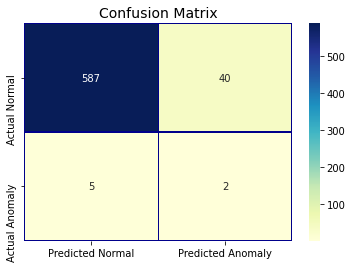

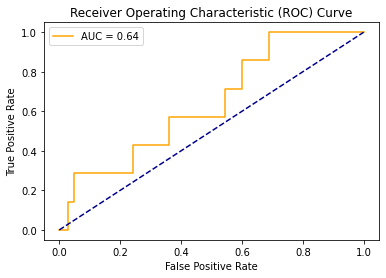

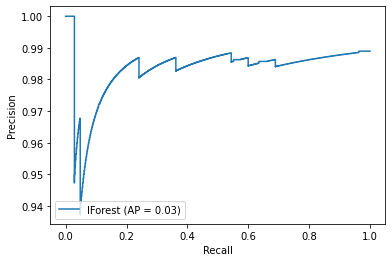

In [ ]:
#Oversampled
#Not Standardized
get_prediction(IForest(n_estimators = 150, max_samples = 256, contamination = 0.05, random_state= 42), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

On Training Data:
IForest ROC:0.8939, precision @ rank n:0.1579

On Test Data:
IForest ROC:0.7765, precision @ rank n:0.1429

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       627
           1       0.20      0.29      0.24         7

    accuracy                           0.98       634
   macro avg       0.60      0.64      0.61       634
weighted avg       0.98      0.98      0.98       634


 IForest Matthews Correlation Coefficient 0.2289189434429588

 IForest f1-score 0.23529411764705882


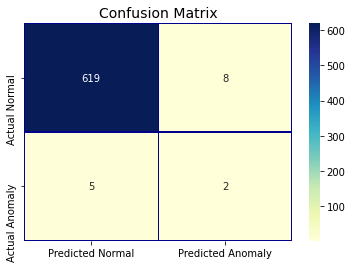

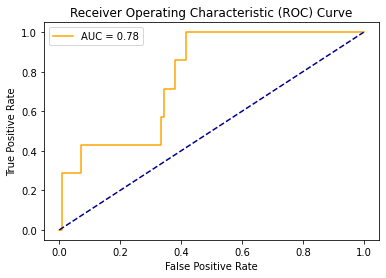

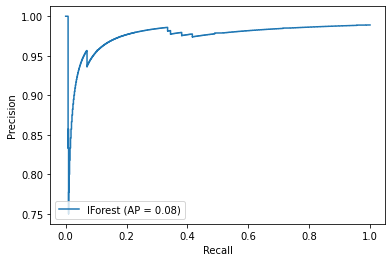

In [ ]:
#Not Oversampled
#Not Standardized
get_prediction(IForest(n_estimators = 50, max_samples = 256, contamination = 0.01, random_state=42), 
               train_X, test_X, train_y, test_y, 'IForest')

## SciForest-Isotree

---




 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       627
           1       0.00      0.00      0.00         7

    accuracy                           0.97       634
   macro avg       0.49      0.49      0.49       634
weighted avg       0.98      0.97      0.98       634


 SciForest  Confusion Matrix: 
 [[617  10]
 [  7   0]]

 SciForest Matthews Correlation Coefficient -0.013375898197835656

 SciForest f1-score 0.0


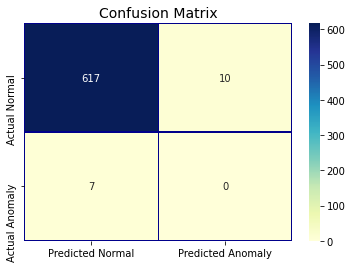

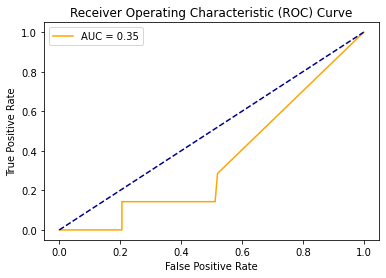

In [ ]:
#Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=150, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_resampled, test_X, train_y_resampled, test_y, 'SciForest')


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       627
           1       0.00      0.00      0.00         7

    accuracy                           0.99       634
   macro avg       0.49      0.50      0.50       634
weighted avg       0.98      0.99      0.98       634


 SciForest  Confusion Matrix: 
 [[627   0]
 [  7   0]]

 SciForest Matthews Correlation Coefficient 0.0

 SciForest f1-score 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


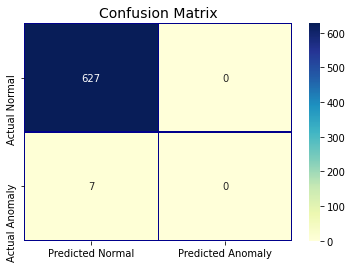

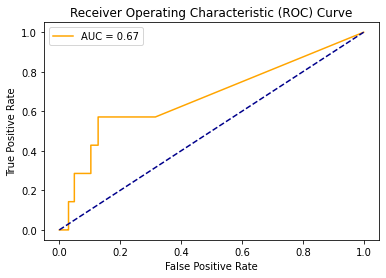

In [ ]:
#Not Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=50, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')

## OCSVM

---



On Training Data:
OCSVM ROC:0.3204, precision @ rank n:0.3873

On Test Data:
OCSVM ROC:0.4732, precision @ rank n:0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       627
           1       0.00      0.00      0.00         7

    accuracy                           0.96       634
   macro avg       0.49      0.49      0.49       634
weighted avg       0.98      0.96      0.97       634


 OCSVM Matthews Correlation Coefficient -0.01806180486906878

 OCSVM f1-score 0.0


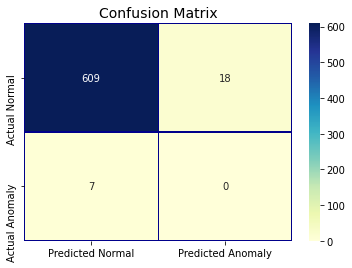

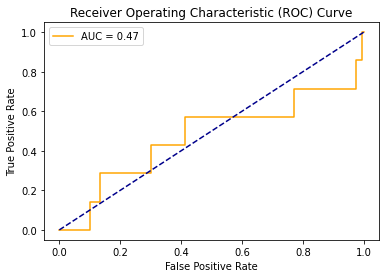

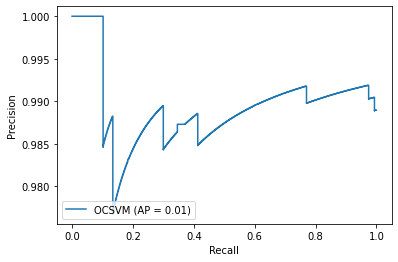

In [ ]:
#Oversampled
#Standardized
get_prediction(OCSVM(gamma = 0.0001, contamination= 0.01, kernel = 'rbf'),
               train_X_resampled, test_X, train_y_resampled, test_y, 'OCSVM')

On Training Data:
OCSVM ROC:0.7377, precision @ rank n:0.1579

On Test Data:
OCSVM ROC:0.707, precision @ rank n:0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.85      0.91       627
           1       0.03      0.43      0.06         7

    accuracy                           0.84       634
   macro avg       0.51      0.64      0.49       634
weighted avg       0.98      0.84      0.91       634


 OCSVM Matthews Correlation Coefficient 0.0800857693140747

 OCSVM f1-score 0.05714285714285714


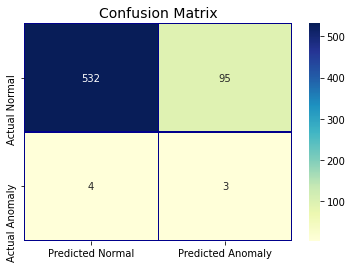

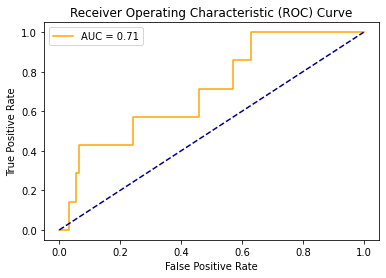

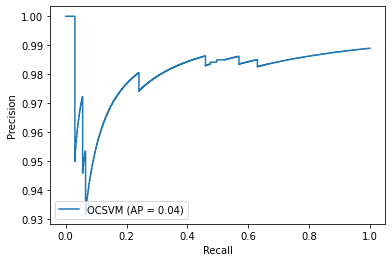

In [ ]:
#Not Oversampled
#Standardized
get_prediction(OCSVM(gamma = 'auto', contamination= 0.1, kernel = 'rbf'),
               train_X, test_X, train_y, test_y, 'OCSVM')

## LOF

---



On Training Data:
LOF ROC:0.3864, precision @ rank n:0.4019

On Test Data:
LOF ROC:0.5395, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       627
           1       0.00      0.00      0.00         7

    accuracy                           0.98       634
   macro avg       0.49      0.50      0.49       634
weighted avg       0.98      0.98      0.98       634


 LOF Matthews Correlation Coefficient -0.01032787690160029

 LOF f1-score 0.0


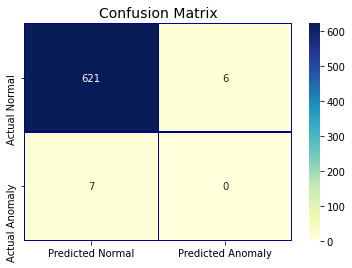

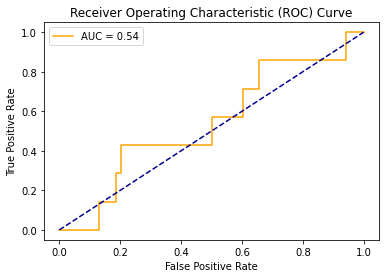

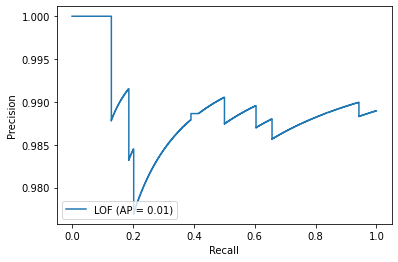

In [ ]:
#Oversampled
#Standardized
get_prediction(LOF(n_neighbors=500, contamination= 0.01, algorithm='auto', metric = 'euclidean'), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'LOF')

On Training Data:
LOF ROC:0.7007, precision @ rank n:0.0

On Test Data:
LOF ROC:0.6853, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       627
           1       0.00      0.00      0.00         7

    accuracy                           0.98       634
   macro avg       0.49      0.50      0.50       634
weighted avg       0.98      0.98      0.98       634


 LOF Matthews Correlation Coefficient -0.0072855307797362046

 LOF f1-score 0.0


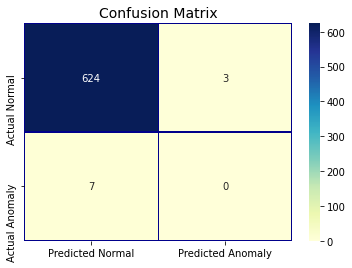

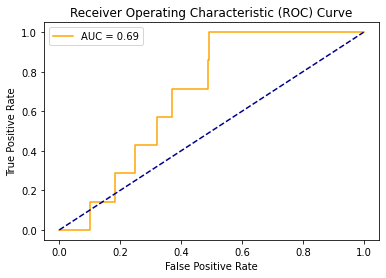

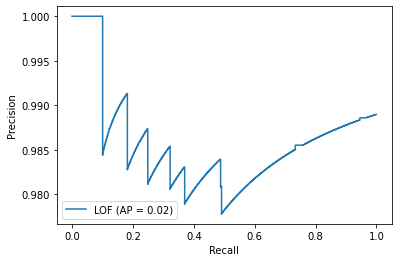

In [ ]:
#Not Oversampled
#Standardized
get_prediction(LOF(n_neighbors=20, contamination= 0.01, algorithm='auto', metric = 'euclidean'), 
               train_X, test_X, train_y, test_y, 'LOF')

## CBLOF

---



On Training Data:
CBLOF ROC:0.3581, precision @ rank n:0.3674

On Test Data:
CBLOF ROC:0.5309, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       627
           1       0.00      0.00      0.00         7

    accuracy                           0.98       634
   macro avg       0.49      0.50      0.50       634
weighted avg       0.98      0.98      0.98       634


 CBLOF Matthews Correlation Coefficient -0.009420521152100797

 CBLOF f1-score 0.0


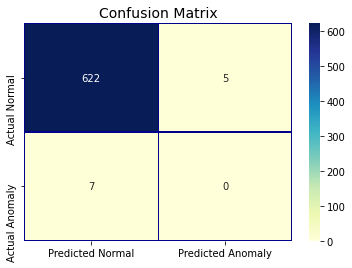

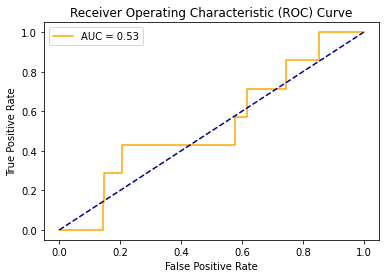

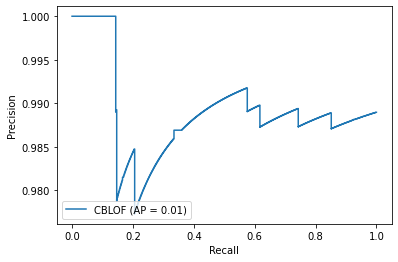

In [ ]:
#Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.01, n_clusters= 20, alpha= 0.9, beta= 20), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.7226, precision @ rank n:0.0526

On Test Data:
CBLOF ROC:0.7093, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       627
           1       0.02      0.14      0.03         7

    accuracy                           0.89       634
   macro avg       0.50      0.52      0.49       634
weighted avg       0.98      0.89      0.93       634


 CBLOF Matthews Correlation Coefficient 0.014699505970295963

 CBLOF f1-score 0.028169014084507043


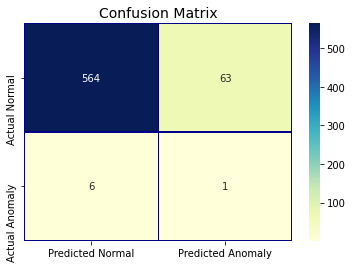

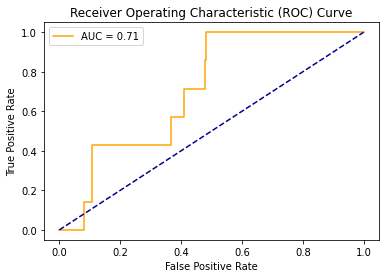

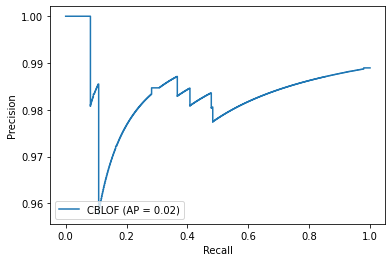

In [ ]:
#Not Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.1, n_clusters= 25, alpha= 0.9, beta= 20), 
               train_X, test_X, train_y, test_y, 'CBLOF')

## KNN

---



On Training Data:
KNN ROC:0.6741, precision @ rank n:0.0

On Test Data:
KNN ROC:0.6525, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       627
           1       0.00      0.00      0.00         7

    accuracy                           0.98       634
   macro avg       0.49      0.50      0.50       634
weighted avg       0.98      0.98      0.98       634


 KNN Matthews Correlation Coefficient -0.009420521152100797

 KNN f1-score 0.0


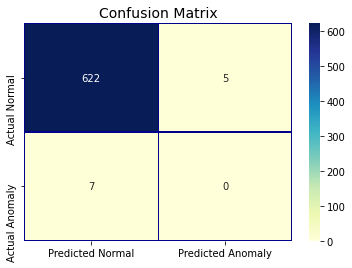

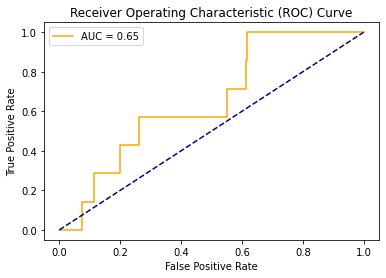

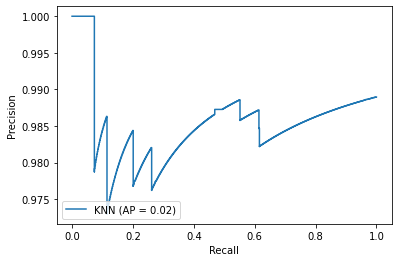

In [ ]:
#Not Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 500, method= 'median', algorithm='auto',contamination= 0.01), 
               train_X, test_X, train_y, test_y, 'KNN')

On Training Data:
KNN ROC:0.1734, precision @ rank n:0.2004

On Test Data:
KNN ROC:0.6236, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.85      0.92       627
           1       0.02      0.29      0.04         7

    accuracy                           0.85       634
   macro avg       0.51      0.57      0.48       634
weighted avg       0.98      0.85      0.91       634


 KNN Matthews Correlation Coefficient 0.04152047055654526

 KNN f1-score 0.04000000000000001


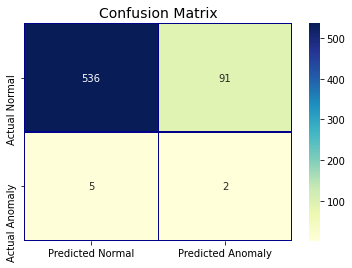

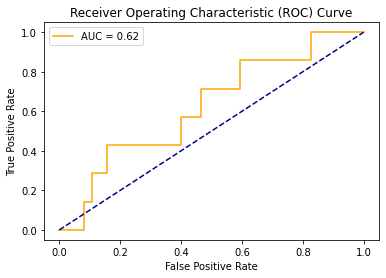

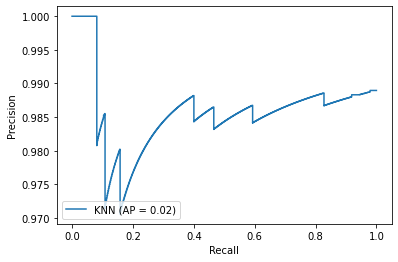

In [ ]:
#Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 20, method= 'mean', algorithm='auto',contamination= 0.07), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'KNN')

## ABOD
---

In [ ]:
from pyod.models.abod import ABOD
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

0.0

  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       628
     Anomaly       0.00      0.00      0.00         6

    accuracy                           0.98       634
   macro avg       0.50      0.50      0.50       634
weighted avg       0.98      0.98      0.98       634


 Matthews Correlation Coefficient -0.009554140127388535

 f1-score 0.0

 Balanced Accuracy 0.49522292993630573


Text(0.5, 1.0, 'Confusion Matrix')

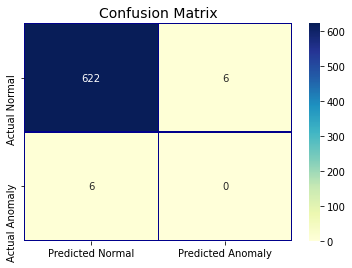

In [ ]:
#Oversampled
#Standardized
clf = ABOD(contamination=0.01, n_neighbors=95, method= 'fast').fit(train_X_resampled)
pred = clf.predict(test_X)

#Evaluate using Pyod built-in function
print(recall_score(test_y,pred))
    
print("\n", " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
#print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
print("\n", "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
print("\n", "f1-score", f1_score(test_y, pred))
print("\n", "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

sns.heatmap(data = confusion_matrix(test_y, pred),
               xticklabels = ['Predicted Normal','Predicted Anomaly'],
               yticklabels = ['Actual Normal','Actual Anomaly'],
               linewidths=.2,
               cmap = "YlGnBu",
               linecolor="Darkblue",
               fmt = 'd',
               annot = True)
plt.title('Confusion Matrix', fontsize = 14)
    

0.0

  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       628
     Anomaly       0.00      0.00      0.00         6

    accuracy                           0.98       634
   macro avg       0.50      0.50      0.50       634
weighted avg       0.98      0.98      0.98       634


 Matthews Correlation Coefficient -0.009554140127388535

 f1-score 0.0

 Balanced Accuracy 0.49522292993630573


Text(0.5, 1.0, 'Confusion Matrix')

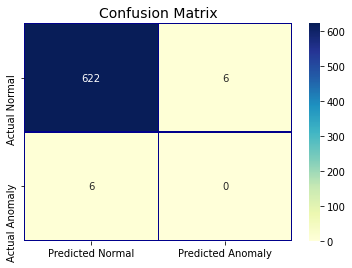

In [ ]:
#Not Oversampled
#Standardized
clf = ABOD(contamination=0.01, n_neighbors=95, method= 'fast').fit(train_X)
pred = clf.predict(test_X)

#Evaluate using Pyod built-in function
print(recall_score(test_y,pred))
    
print("\n", " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
#print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
print("\n", "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
print("\n", "f1-score", f1_score(test_y, pred))
print("\n", "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

sns.heatmap(data = confusion_matrix(test_y, pred),
               xticklabels = ['Predicted Normal','Predicted Anomaly'],
               yticklabels = ['Actual Normal','Actual Anomaly'],
               linewidths=.2,
               cmap = "YlGnBu",
               linecolor="Darkblue",
               fmt = 'd',
               annot = True)
plt.title('Confusion Matrix', fontsize = 14)
    

IForest-Isotree

---



In [ ]:
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 128, ndim=1, ntrees=50, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'IForest')

SciForest-Isotree

---



In [ ]:
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_resampled, test_X, train_y_resampled, test_y, 'SciForest')

In [ ]:

get_prediction_iso(IsolationForest(sample_size = 128, ndim=2, ntrees=50, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')

# BM_925 : scattered 

In [ ]:
X, y = split_x_y(bm_925)

In [ ]:
#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, stratify=y) 

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25) 

In [ ]:
#Standardization
scaler = RobustScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [ ]:
#Oversampling with Adasyn
train_X_resampled, train_y_resampled= ADASYN(ratio = 'minority').fit_sample(train_X, train_y)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

### IForest

---



In [ ]:
#Oversampled
#Not Standardized
get_prediction(IForest(n_estimators = 150, max_samples = 256, contamination = 0.05, random_state= 42), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

In [ ]:
#Not Oversampled
#Not Standardized
get_prediction(IForest(n_estimators = 50, max_samples = 256, contamination = 0.01, random_state=42), 
               train_X, test_X, train_y, test_y, 'IForest')

## SciForest-Isotree

---



In [ ]:
#Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=150, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_resampled, test_X, train_y_resampled, test_y, 'SciForest')

In [ ]:
#Not Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=50, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')

## OCSVM

---



In [ ]:
#Oversampled
#Standardized
get_prediction(OCSVM(gamma = 0.0001, contamination= 0.01, kernel = 'rbf'),
               train_X_resampled, test_X, train_y_resampled, test_y, 'OCSVM')

In [ ]:
#Not Oversampled
#Standardized
get_prediction(OCSVM(gamma = 'auto', contamination= 0.1, kernel = 'rbf'),
               train_X, test_X, train_y, test_y, 'OCSVM')

## LOF

---



In [ ]:
#Oversampled
#Standardized
get_prediction(LOF(n_neighbors=500, contamination= 0.01, algorithm='auto', metric = 'euclidean'), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'LOF')

In [ ]:
#Not Oversampled
#Standardized
get_prediction(LOF(n_neighbors=20, contamination= 0.01, algorithm='auto', metric = 'euclidean'), 
               train_X, test_X, train_y, test_y, 'LOF')

## CBLOF

---



In [ ]:
#Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.01, n_clusters= 20, alpha= 0.9, beta= 20), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'CBLOF')

In [ ]:
#Not Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.1, n_clusters= 25, alpha= 0.9, beta= 20), 
               train_X, test_X, train_y, test_y, 'CBLOF')

## KNN

---



In [ ]:
#Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 500, method= 'median', algorithm='auto',contamination= 0.01), 
               train_X, test_X, train_y, test_y, 'KNN')

In [ ]:
#Not Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 20, method= 'mean', algorithm='auto',contamination= 0.07), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'KNN')

## ABOD
---

In [ ]:
from pyod.models.abod import ABOD
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

0.0

  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.98      0.99       631
     Anomaly       0.00      0.00      0.00         3

    accuracy                           0.98       634
   macro avg       0.50      0.49      0.49       634
weighted avg       0.99      0.98      0.98       634


 Matthews Correlation Coefficient -0.009162168340345958

 f1-score 0.0

 Balanced Accuracy 0.49128367670364503


Text(0.5, 1.0, 'Confusion Matrix')

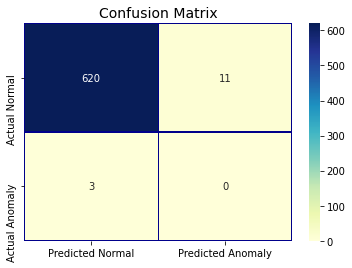

In [ ]:
#Oversampled
#Standardized
clf = ABOD(contamination=0.01, n_neighbors=95, method= 'fast').fit(train_X_resampled)
pred = clf.predict(test_X)

#Evaluate using Pyod built-in function
print(recall_score(test_y,pred))
    
print("\n", " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
#print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
print("\n", "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
print("\n", "f1-score", f1_score(test_y, pred))
print("\n", "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

sns.heatmap(data = confusion_matrix(test_y, pred),
               xticklabels = ['Predicted Normal','Predicted Anomaly'],
               yticklabels = ['Actual Normal','Actual Anomaly'],
               linewidths=.2,
               cmap = "YlGnBu",
               linecolor="Darkblue",
               fmt = 'd',
               annot = True)
plt.title('Confusion Matrix', fontsize = 14)


0.0

  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.99      0.99       631
     Anomaly       0.00      0.00      0.00         3

    accuracy                           0.99       634
   macro avg       0.50      0.50      0.50       634
weighted avg       0.99      0.99      0.99       634


 Matthews Correlation Coefficient -0.006147600357553005

 f1-score 0.0

 Balanced Accuracy 0.4960380348652932


Text(0.5, 1.0, 'Confusion Matrix')

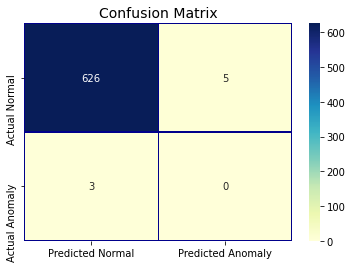

In [ ]:
#Not Oversampled
#Standardized
lf = ABOD(contamination=0.01, n_neighbors=95, method= 'fast').fit(train_X)
pred = clf.predict(test_X)

#Evaluate using Pyod built-in function
print(recall_score(test_y,pred))
    
print("\n", " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
#print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
print("\n", "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
print("\n", "f1-score", f1_score(test_y, pred))
print("\n", "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

sns.heatmap(data = confusion_matrix(test_y, pred),
               xticklabels = ['Predicted Normal','Predicted Anomaly'],
               yticklabels = ['Actual Normal','Actual Anomaly'],
               linewidths=.2,
               cmap = "YlGnBu",
               linecolor="Darkblue",
               fmt = 'd',
               annot = True)
plt.title('Confusion Matrix', fontsize = 14)
    

# BM_944 : least clustered 

In [ ]:
X, y = split_x_y(bm_944)

In [ ]:
#Stratified split
#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, stratify=y) 

In [ ]:
#Regular split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25) 

In [ ]:
#Standardization
scaler = RobustScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [ ]:
#Oversampling with Adasyn
train_X_resampled, train_y_resampled= ADASYN(ratio = 'minority').fit_sample(train_X, train_y)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

### IForest

---



In [ ]:
#Oversampled
#Not Standardized
get_prediction(IForest(n_estimators = 150, max_samples = 256, contamination = 0.05, random_state= 42), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

On Training Data:
IForest ROC:0.8064, precision @ rank n:0.1176

On Test Data:
IForest ROC:0.8306, precision @ rank n:0.2222

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       625
           1       0.25      0.22      0.24         9

    accuracy                           0.98       634
   macro avg       0.62      0.61      0.61       634
weighted avg       0.98      0.98      0.98       634


 IForest Matthews Correlation Coefficient 0.2253397230190963

 IForest f1-score 0.23529411764705882


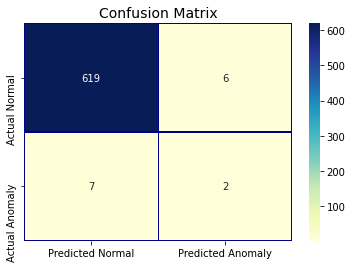

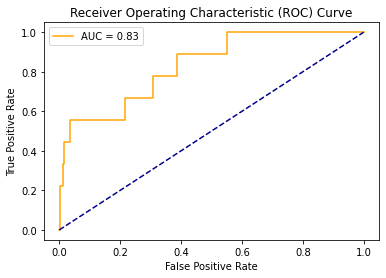

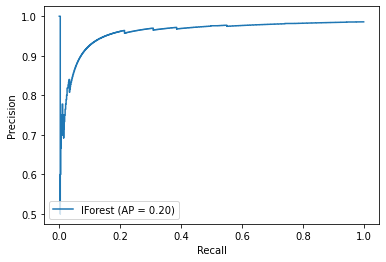

In [ ]:
#Not Oversampled
#Not Standardized
get_prediction(IForest(n_estimators = 50, max_samples = 256, contamination = 0.01, random_state=42), 
               train_X, test_X, train_y, test_y, 'IForest')

## OCSVM

---



In [ ]:
#Oversampled
#Standardized
get_prediction(OCSVM(gamma = 0.0001, contamination= 0.01, kernel = 'rbf'),
               train_X_resampled, test_X, train_y_resampled, test_y, 'OCSVM')

In [ ]:
#Not Oversampled
#Standardized
get_prediction(OCSVM(gamma = 'auto', contamination= 0.1, kernel = 'rbf'),
               train_X, test_X, train_y, test_y, 'OCSVM')

## LOF

---



In [ ]:
#Oversampled
#Standardized
get_prediction(LOF(n_neighbors=500, contamination= 0.01, algorithm='auto', metric = 'euclidean'), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'LOF')

On Training Data:
LOF ROC:0.6395, precision @ rank n:0.0

On Test Data:
LOF ROC:0.7512, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       627
           1       0.00      0.00      0.00         7

    accuracy                           0.99       634
   macro avg       0.49      0.50      0.50       634
weighted avg       0.98      0.99      0.98       634


 LOF Matthews Correlation Coefficient -0.004199652871039927

 LOF f1-score 0.0


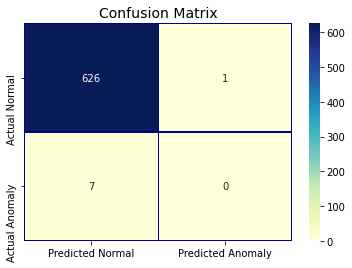

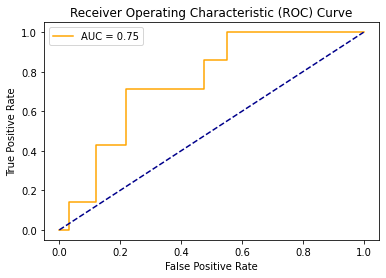

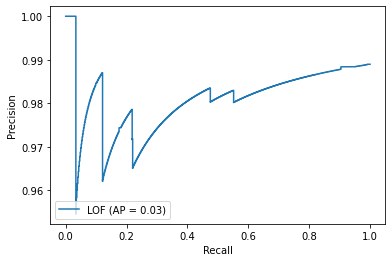

In [ ]:
#Not Oversampled
#Standardized
get_prediction(LOF(n_neighbors=20, contamination= 0.01, algorithm='auto', metric = 'euclidean'), 
               train_X, test_X, train_y, test_y, 'LOF')

## CBLOF

---



In [ ]:
#Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.01, n_clusters= 20, alpha= 0.9, beta= 20), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.6898, precision @ rank n:0.0

On Test Data:
CBLOF ROC:0.6389, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       627
           1       0.04      0.29      0.07         7

    accuracy                           0.91       634
   macro avg       0.51      0.60      0.51       634
weighted avg       0.98      0.91      0.94       634


 CBLOF Matthews Correlation Coefficient 0.07590953647849479

 CBLOF f1-score 0.06557377049180328


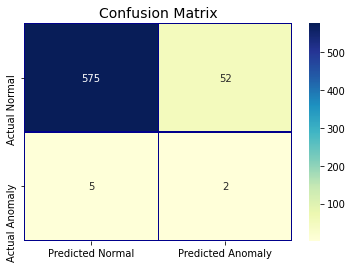

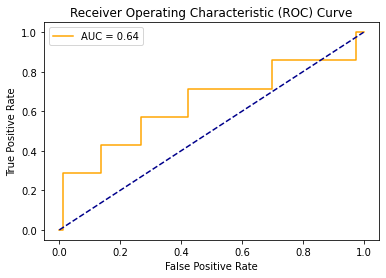

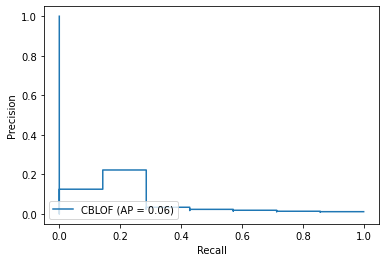

In [ ]:
#Not Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.1, n_clusters= 25, alpha= 0.9, beta= 20), 
               train_X, test_X, train_y, test_y, 'CBLOF')

## KNN

---



In [ ]:
#Not Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 500, method= 'median', algorithm='auto',contamination= 0.01), 
               train_X, test_X, train_y, test_y, 'KNN')

In [ ]:
#Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 20, method= 'mean', algorithm='auto',contamination= 0.07), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'KNN')

## ABOD
---

In [ ]:
from pyod.models.abod import ABOD
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

0.0

  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       629
     Anomaly       0.00      0.00      0.00         5

    accuracy                           0.99       634
   macro avg       0.50      0.50      0.50       634
weighted avg       0.98      0.99      0.99       634


 Matthews Correlation Coefficient -0.006147600357553005

 f1-score 0.0

 Balanced Accuracy 0.49761526232114467


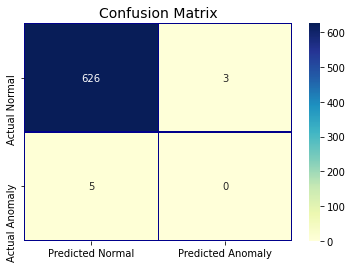

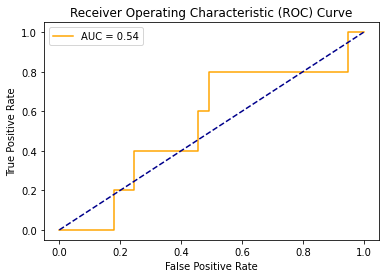

In [ ]:
#Oversampled
#Standardized
clf = ABOD(contamination=0.01, n_neighbors=95, method= 'fast').fit(train_X_resampled)
pred = clf.predict(test_X)

#Evaluate using Pyod built-in function
print(recall_score(test_y,pred))
    
print("\n", " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
#print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
print("\n", "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
print("\n", "f1-score", f1_score(test_y, pred))
print("\n", "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

sns.heatmap(data = confusion_matrix(test_y, pred),
               xticklabels = ['Predicted Normal','Predicted Anomaly'],
               yticklabels = ['Actual Normal','Actual Anomaly'],
               linewidths=.2,
               cmap = "YlGnBu",
               linecolor="Darkblue",
               fmt = 'd',
               annot = True)
plt.title('Confusion Matrix', fontsize = 14)
    
plt.figure()
model_decision = clf.decision_function(test_X)
fpr, tpr, threshold = roc_curve(test_y, model_decision)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

0.0

  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       629
     Anomaly       0.00      0.00      0.00         5

    accuracy                           0.99       634
   macro avg       0.50      0.50      0.50       634
weighted avg       0.98      0.99      0.99       634


 Matthews Correlation Coefficient -0.005015521981550779

 f1-score 0.0

 Balanced Accuracy 0.4984101748807631


Text(0.5, 1.0, 'Confusion Matrix')

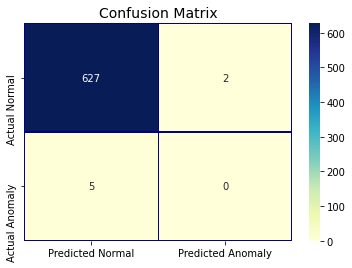

In [ ]:
#Not Oversampled
#Standardized
clf = ABOD(contamination=0.01, n_neighbors=95, method= 'fast').fit(train_X)
pred = clf.predict(test_X)

#Evaluate using Pyod built-in function
print(recall_score(test_y,pred))
    
print("\n", " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
#print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
print("\n", "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
print("\n", "f1-score", f1_score(test_y, pred))
print("\n", "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

sns.heatmap(data = confusion_matrix(test_y, pred),
               xticklabels = ['Predicted Normal','Predicted Anomaly'],
               yticklabels = ['Actual Normal','Actual Anomaly'],
               linewidths=.2,
               cmap = "YlGnBu",
               linecolor="Darkblue",
               fmt = 'd',
               annot = True)
plt.title('Confusion Matrix', fontsize = 14)
    

## SciForest-Isotree

---



In [ ]:
#Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=150, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_resampled, test_X, train_y_resampled, test_y, 'SciForest')


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       630
           1       0.20      0.25      0.22         4

    accuracy                           0.99       634
   macro avg       0.60      0.62      0.61       634
weighted avg       0.99      0.99      0.99       634


 SciForest  Confusion Matrix: 
 [[626   4]
 [  3   1]]

 SciForest Matthews Correlation Coefficient 0.21810105977265362

 SciForest f1-score 0.22222222222222224


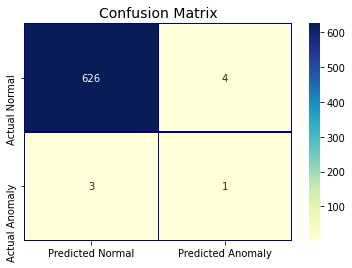

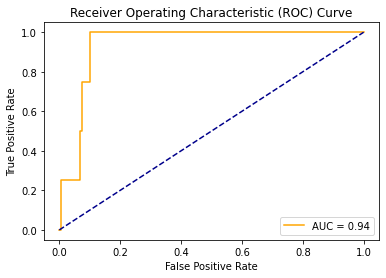

In [ ]:
#Not Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=50, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')

# BM_943 : most clustered 

In [ ]:
X, y = split_x_y(bm_943)

In [ ]:
#Stratified Split
#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, stratify=y) 

In [ ]:
#Regular split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25) 

In [ ]:
#Standardization
scaler = RobustScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [ ]:
#Oversampling with Adasyn
train_X_resampled, train_y_resampled= ADASYN(ratio = 'minority').fit_sample(train_X, train_y)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

Percentage Training Set Contamination:  0.009994739610731194
Percentage Test Set Contamination:      0.011041009463722398


### IForest

---



In [ ]:
#Oversampled
#Not Standardized
get_prediction(IForest(n_estimators = 150, max_samples = 256, contamination = 0.05, random_state= 42), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

On Training Data:
IForest ROC:0.6438, precision @ rank n:0.1579

On Test Data:
IForest ROC:0.5995, precision @ rank n:0.0

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       627
           1       0.00      0.00      0.00         7

    accuracy                           0.98       634
   macro avg       0.49      0.49      0.49       634
weighted avg       0.98      0.98      0.98       634


 IForest Matthews Correlation Coefficient -0.011164274322169059

 IForest f1-score 0.0


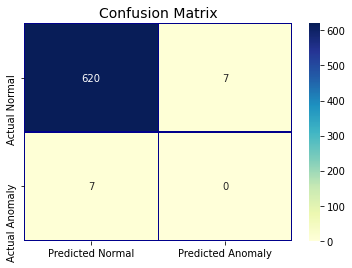

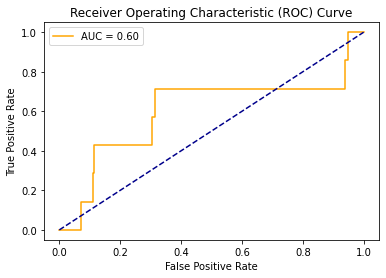

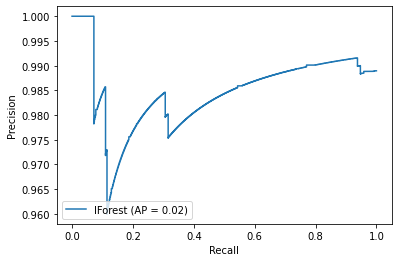

In [ ]:
#Not Oversampled
#Not Standardized
get_prediction(IForest(n_estimators = 50, max_samples = 256, contamination = 0.01, random_state=42), 
               train_X, test_X, train_y, test_y, 'IForest')

## OCSVM

---



In [ ]:
#Oversampled
#Standardized
get_prediction(OCSVM(gamma = 0.0001, contamination= 0.01, kernel = 'rbf'),
               train_X_resampled, test_X, train_y_resampled, test_y, 'OCSVM')

In [ ]:
#Not Oversampled
#Standardized
get_prediction(OCSVM(gamma = 'auto', contamination= 0.1, kernel = 'rbf'),
               train_X, test_X, train_y, test_y, 'OCSVM')

## LOF

---



In [ ]:
#Oversampled
#Standardized
get_prediction(LOF(n_neighbors=500, contamination= 0.01, algorithm='auto', metric = 'euclidean'), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'LOF')

On Training Data:
LOF ROC:0.552, precision @ rank n:0.0

On Test Data:
LOF ROC:0.4165, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       627
           1       0.00      0.00      0.00         7

    accuracy                           0.98       634
   macro avg       0.49      0.50      0.50       634
weighted avg       0.98      0.98      0.98       634


 LOF Matthews Correlation Coefficient -0.00841928033804536

 LOF f1-score 0.0


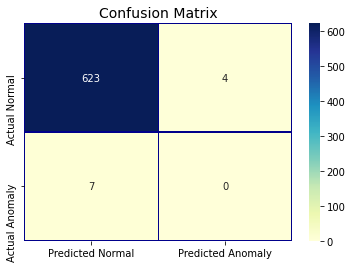

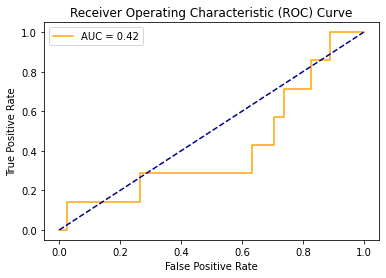

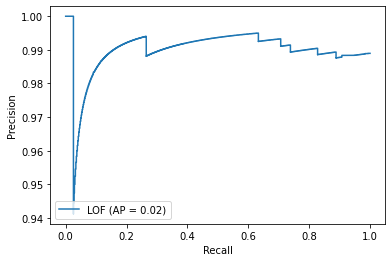

In [ ]:
#Not Oversampled
#Standardized
get_prediction(LOF(n_neighbors=20, contamination= 0.01, algorithm='auto', metric = 'euclidean'), 
               train_X, test_X, train_y, test_y, 'LOF')

## CBLOF

---



In [ ]:
#Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.01, n_clusters= 20, alpha= 0.9, beta= 20), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.585, precision @ rank n:0.0526

On Test Data:
CBLOF ROC:0.4482, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.89      0.94       627
           1       0.01      0.14      0.03         7

    accuracy                           0.89       634
   macro avg       0.50      0.52      0.48       634
weighted avg       0.98      0.89      0.93       634


 CBLOF Matthews Correlation Coefficient 0.01277827478488829

 CBLOF f1-score 0.02702702702702703


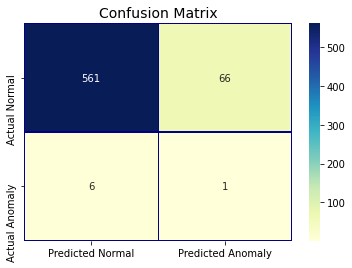

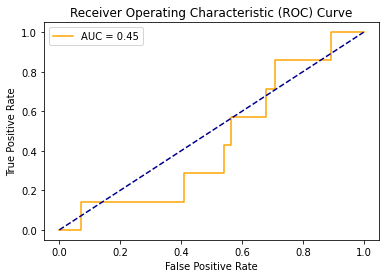

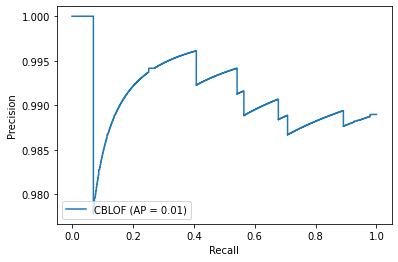

In [ ]:
#Not Oversampled
#Standardized
get_prediction(CBLOF(contamination= 0.1, n_clusters= 25, alpha= 0.9, beta= 20), 
               train_X, test_X, train_y, test_y, 'CBLOF')

## KNN

---



In [ ]:
#Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 500, method= 'median', algorithm='auto',contamination= 0.01), 
               train_X, test_X, train_y, test_y, 'KNN')

In [ ]:
#Not Oversampled
#Standardized
get_prediction(KNN(n_neighbors= 20, method= 'mean', algorithm='auto',contamination= 0.07), 
               train_X_resampled, test_X, train_y_resampled, test_y, 'KNN')

## ABOD
---

In [ ]:
from pyod.models.abod import ABOD
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

0.0

  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       629
     Anomaly       0.00      0.00      0.00         5

    accuracy                           0.99       634
   macro avg       0.50      0.50      0.50       634
weighted avg       0.98      0.99      0.99       634


 Matthews Correlation Coefficient -0.006147600357553005

 f1-score 0.0

 Balanced Accuracy 0.49761526232114467


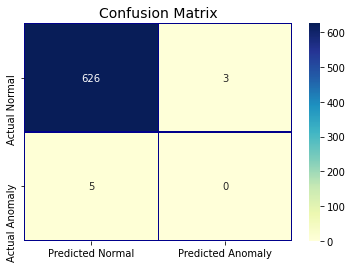

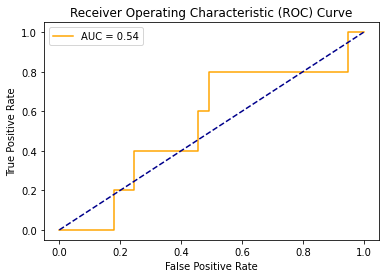

In [ ]:
#Oversampled
#Standardized
clf = ABOD(contamination=0.01, n_neighbors=95, method= 'fast').fit(train_X_resampled)
pred = clf.predict(test_X)

#Evaluate using Pyod built-in function
print(recall_score(test_y,pred))  
print("\n", " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
#print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
print("\n", "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
print("\n", "f1-score", f1_score(test_y, pred))
print("\n", "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

sns.heatmap(data = confusion_matrix(test_y, pred),
               xticklabels = ['Predicted Normal','Predicted Anomaly'],
               yticklabels = ['Actual Normal','Actual Anomaly'],
               linewidths=.2,
               cmap = "YlGnBu",
               linecolor="Darkblue",
               fmt = 'd',
               annot = True)
plt.title('Confusion Matrix', fontsize = 14)
    
plt.figure()
model_decision = clf.decision_function(test_X)
fpr, tpr, threshold = roc_curve(test_y, model_decision)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

0.0

  Classification Report: 
               precision    recall  f1-score   support

      Normal       0.99      1.00      0.99       629
     Anomaly       0.00      0.00      0.00         5

    accuracy                           0.99       634
   macro avg       0.50      0.50      0.50       634
weighted avg       0.98      0.99      0.99       634


 Matthews Correlation Coefficient -0.005015521981550779

 f1-score 0.0

 Balanced Accuracy 0.4984101748807631


Text(0.5, 1.0, 'Confusion Matrix')

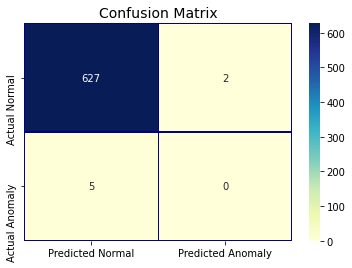

In [ ]:
#Not Oversampled
#Standardized
clf = ABOD(contamination=0.01, n_neighbors=95, method= 'fast').fit(train_X)
pred = clf.predict(test_X)

#Evaluate using Pyod built-in function
print(recall_score(test_y,pred))
    
print("\n", " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly']))
#print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(list_testy, pred))
print("\n", "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
print("\n", "f1-score", f1_score(test_y, pred))
print("\n", "Balanced Accuracy", balanced_accuracy_score(test_y, pred))

sns.heatmap(data = confusion_matrix(test_y, pred),
               xticklabels = ['Predicted Normal','Predicted Anomaly'],
               yticklabels = ['Actual Normal','Actual Anomaly'],
               linewidths=.2,
               cmap = "YlGnBu",
               linecolor="Darkblue",
               fmt = 'd',
               annot = True)
plt.title('Confusion Matrix', fontsize = 14)
    

## SciForest-Isotree

---



In [ ]:
#Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=150, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X_resampled, test_X, train_y_resampled, test_y, 'SciForest')


 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       629
           1       0.00      0.00      0.00         5

    accuracy                           0.99       634
   macro avg       0.50      0.50      0.50       634
weighted avg       0.98      0.99      0.99       634


 SciForest  Confusion Matrix: 
 [[626   3]
 [  5   0]]

 SciForest Matthews Correlation Coefficient -0.006147600357553005

 SciForest f1-score 0.0


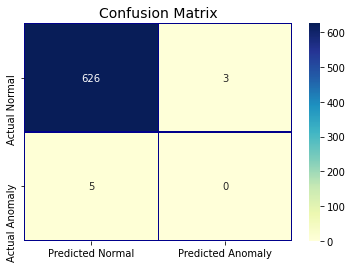

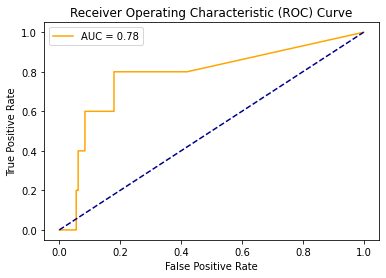

In [ ]:
#Not Oversampled
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=150, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')